# scIDiff Basic Usage Tutorial (Fixed Version)

This notebook demonstrates the basic usage of scIDiff for single-cell gene expression modeling and inverse design.

## Setup Instructions

Before running this notebook, make sure to install the package in development mode:

```bash
# Navigate to the scIDiff directory
cd /path/to/scIDiff

# Install in development mode
pip install -e .
```

Or if you're running from the repository directory, you can add the path to sys.path as shown below.

In [1]:
# Add the parent directory to Python path (if not installed as package)
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Import necessary libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.6.0


In [2]:
# Import scIDiff components
try:
    # Try importing as installed package
    from scIDiff.models import ScIDiffModel
    from scIDiff.training import ScIDiffTrainer
    from scIDiff.sampling import InverseDesigner, PhenotypeTarget, GeneExpressionObjective
    from scIDiff.data import SingleCellDataset
    print("Successfully imported scIDiff components!")
except ImportError as e:
    print(f"Import error: {e}")
    print("Please install the package using: pip install -e .")
    print("Or make sure you're running from the correct directory.")

Successfully imported scIDiff components!


## 1. Data Preparation

First, let's create some synthetic single-cell data for demonstration purposes.

In [3]:
# Create synthetic single-cell data
def create_synthetic_data(n_cells=1000, n_genes=2000, n_cell_types=5):
    """
    Create synthetic single-cell RNA-seq data
    """
    # Generate cell type labels
    cell_types = np.random.randint(0, n_cell_types, n_cells)
    
    # Generate gene expression data with cell type specific patterns
    expression_data = []
    
    for cell_type in range(n_cell_types):
        n_cells_type = np.sum(cell_types == cell_type)
        
        # Create cell type specific expression pattern
        base_expression = np.random.lognormal(0, 1, (n_cells_type, n_genes))
        
        # Add cell type specific markers
        marker_genes = np.random.choice(n_genes, 50, replace=False)
        base_expression[:, marker_genes] *= (cell_type + 1) * 2
        
        # Add sparsity (many genes are not expressed)
        sparsity_mask = np.random.random((n_cells_type, n_genes)) < 0.7
        base_expression[sparsity_mask] = 0
        
        expression_data.append(base_expression)
    
    # Combine all cell types
    expression_matrix = np.vstack(expression_data)
    
    return expression_matrix, cell_types

# Generate synthetic data
expression_data, cell_type_labels = create_synthetic_data()

print(f"Expression data shape: {expression_data.shape}")
print(f"Cell types: {np.unique(cell_type_labels)}")
print(f"Sparsity: {(expression_data == 0).mean():.2%}")

Expression data shape: (1000, 2000)
Cell types: [0 1 2 3 4]
Sparsity: 70.04%


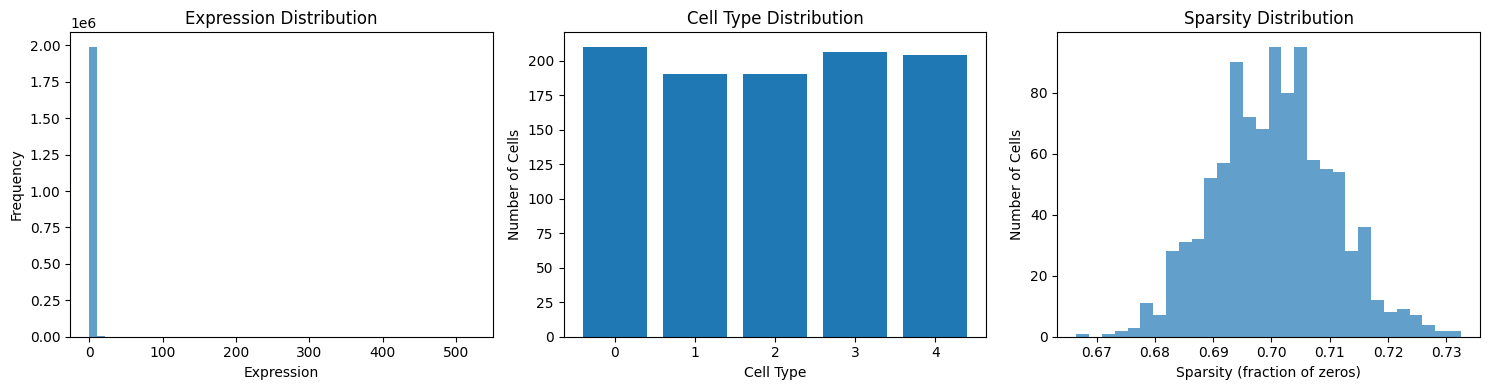

In [4]:
# Visualize the data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Expression distribution
axes[0].hist(expression_data.flatten(), bins=50, alpha=0.7)
axes[0].set_xlabel('Expression')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Expression Distribution')

# Cell type distribution
unique, counts = np.unique(cell_type_labels, return_counts=True)
axes[1].bar(unique, counts)
axes[1].set_xlabel('Cell Type')
axes[1].set_ylabel('Number of Cells')
axes[1].set_title('Cell Type Distribution')

# Sparsity per cell
sparsity_per_cell = (expression_data == 0).mean(axis=1)
axes[2].hist(sparsity_per_cell, bins=30, alpha=0.7)
axes[2].set_xlabel('Sparsity (fraction of zeros)')
axes[2].set_ylabel('Number of Cells')
axes[2].set_title('Sparsity Distribution')

plt.tight_layout()
plt.show()

## 2. Create Dataset

Use the scIDiff SingleCellDataset class to handle the data.

In [5]:
# Create metadata dictionary
metadata = {
    'cell_type': cell_type_labels,
    'batch': np.random.randint(0, 3, len(cell_type_labels)),  # 3 batches
    'total_counts': expression_data.sum(axis=1)
}

# Create dataset
dataset = SingleCellDataset(
    expression_data=expression_data,
    cell_metadata=metadata,
    normalize=True  # Apply log1p normalization
)

print(f"Dataset created with {len(dataset)} cells")
print(f"Dataset statistics: {dataset.get_statistics()}")
print(f"Cell type categories: {dataset.get_metadata_categories('cell_type')}")

Dataset created with 1000 cells
Dataset statistics: {'n_cells': 1000, 'n_genes': 2000, 'mean_expression': 0.24979881942272186, 'std_expression': 0.490252822637558, 'sparsity': 0.0, 'min_expression': 9.999995427278918e-07, 'max_expression': 6.262767314910889}
Cell type categories: None


In [6]:
# Test dataset access
sample = dataset[0]
print("Sample keys:", list(sample.keys()))
print("Expression shape:", sample['expression'].shape)
print("Cell type:", sample['cell_type'].item())
print("Batch:", sample['batch'].item())

Sample keys: ['expression', 'cell_idx', 'cell_type', 'batch', 'total_counts']
Expression shape: torch.Size([2000])
Cell type: 3.0
Batch: 2.0


## 3. Model Initialization

Now let's initialize the scIDiff model with appropriate parameters.

In [7]:
# Model configuration
model_config = {
    'gene_dim': dataset.n_genes,
    'hidden_dim': 512,
    'num_layers': 6,
    'num_timesteps': 1000,
    'conditioning_dim': 128,
    'dropout': 0.1,
    # 'use_attention': True,  # REMOVE this line
    'activation': 'swish',   # You can set this or leave default
}

model = ScIDiffModel(**model_config)
model = model.to(device)

print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Model device: {next(model.parameters()).device}")

Model initialized with 10,406,737 parameters
Model device: cpu


## 4. Data Loading

Prepare the data for training using PyTorch DataLoader.

In [8]:
from torch.utils.data import DataLoader, random_split

# Split dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batch size: {train_loader.batch_size}")

# Test data loader
batch = next(iter(train_loader))
print("\nBatch keys:", list(batch.keys()))
print("Batch expression shape:", batch['expression'].shape)
print("Batch cell_type shape:", batch['cell_type'].shape)

Training samples: 800
Validation samples: 200
Batch size: 32

Batch keys: ['expression', 'cell_idx', 'cell_type', 'batch', 'total_counts']
Batch expression shape: torch.Size([32, 2000])
Batch cell_type shape: torch.Size([32])


## 5. Model Training

Train the scIDiff model using the prepared data.

In [9]:
# Initialize trainer
trainer = ScIDiffTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    log_dir='./logs',
    checkpoint_dir='./checkpoints',
    use_wandb=False,  # Set to True if you want to use Weights & Biases
    gradient_clip_val=1.0
)

print("Trainer initialized successfully")
print(trainer.get_model_summary())

Trainer initialized successfully

        scIDiff Model Summary:
        Total parameters: 10,406,737
        Trainable parameters: 10,406,737
        Gene dimension: 2000
        Hidden dimension: 512
        Number of layers: 6
        Number of timesteps: 1000
        Conditioning dimension: 128
        


In [10]:
# Train the model (reduced epochs for demo)
trainer.train(
    num_epochs=10,  # Use more epochs for real training
    save_every=2,
    validate_every=1,
    log_every=1
)

print("Training completed!")

2025-08-12 10:37:04,203 - scIDiff.training.trainer - INFO - Starting training for 10 epochs
2025-08-12 10:37:04,208 - scIDiff.training.trainer - INFO - Model has 10406737 parameters
Validation: 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 159.63it/s]
2025-08-12 10:37:04,957 - scIDiff.training.trainer - INFO - Epoch 0: Train Loss: 1.184680, Val Loss: 1.126401, LR: 1.00e-04
2025-08-12 10:37:05,120 - scIDiff.training.trainer - INFO - Saved checkpoint: checkpoints/checkpoint_epoch_0.pt
2025-08-12 10:37:05,177 - root - INFO - Saved checkpoint: checkpoints/model_epoch_000_score_1.126401.pt
Validation: 100%|█████████████████████████████████████████████████| 7/7 [00:00<00:00, 167.24it/s]
2025-08-12 10:37:05,830 - scIDiff.training.trainer - INFO - Epoch 1: Train Loss: 1.106231, Val Loss: 1.086471, LR: 1.00e-04
2025-08-12 10:37:05,885 - root - INFO - Saved checkpoint: checkpoints/model_epoch_001_score_1.086471.pt
Validation: 100%|█████████████████████████████████████

Training completed!


## 6. Sample Generation

Generate new single-cell expression profiles using the trained model.

In [11]:
# Generate unconditional samples
model.eval()
with torch.no_grad():
    generated_samples = model.sample(batch_size=100)
    generated_samples = generated_samples.cpu().numpy()

print(f"Generated samples shape: {generated_samples.shape}")
print(f"Generated samples sparsity: {(generated_samples == 0).mean():.2%}")

Generated samples shape: (100, 2000)
Generated samples sparsity: 0.00%


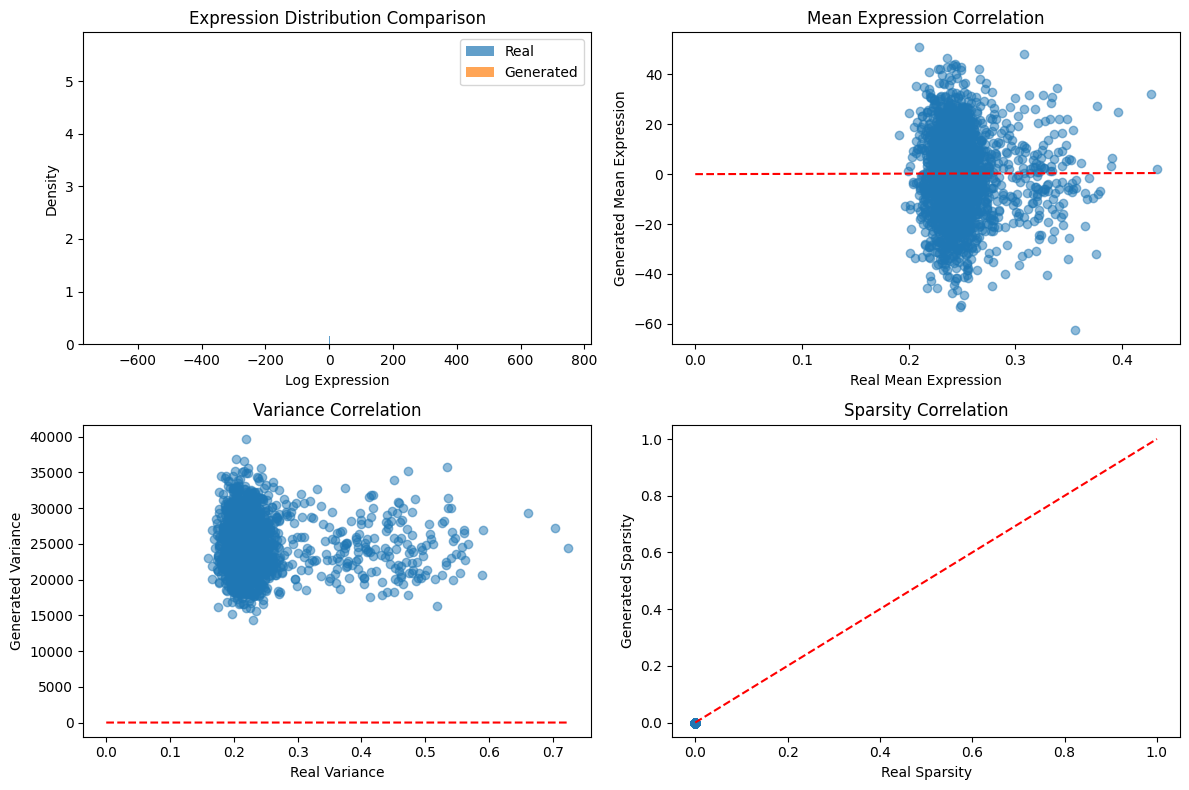

In [12]:
# Compare real vs generated data
real_data = dataset.expression_data.numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Expression distributions
axes[0, 0].hist(real_data.flatten(), bins=50, alpha=0.7, label='Real', density=True)
axes[0, 0].hist(generated_samples.flatten(), bins=50, alpha=0.7, label='Generated', density=True)
axes[0, 0].set_xlabel('Log Expression')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Expression Distribution Comparison')
axes[0, 0].legend()

# Mean expression per gene
real_mean = real_data.mean(axis=0)
gen_mean = generated_samples.mean(axis=0)
axes[0, 1].scatter(real_mean, gen_mean, alpha=0.5)
axes[0, 1].plot([0, real_mean.max()], [0, real_mean.max()], 'r--')
axes[0, 1].set_xlabel('Real Mean Expression')
axes[0, 1].set_ylabel('Generated Mean Expression')
axes[0, 1].set_title('Mean Expression Correlation')

# Variance comparison
real_var = real_data.var(axis=0)
gen_var = generated_samples.var(axis=0)
axes[1, 0].scatter(real_var, gen_var, alpha=0.5)
axes[1, 0].plot([0, real_var.max()], [0, real_var.max()], 'r--')
axes[1, 0].set_xlabel('Real Variance')
axes[1, 0].set_ylabel('Generated Variance')
axes[1, 0].set_title('Variance Correlation')

# Sparsity comparison
real_sparsity = (real_data == 0).mean(axis=0)
gen_sparsity = (generated_samples == 0).mean(axis=0)
axes[1, 1].scatter(real_sparsity, gen_sparsity, alpha=0.5)
axes[1, 1].plot([0, 1], [0, 1], 'r--')
axes[1, 1].set_xlabel('Real Sparsity')
axes[1, 1].set_ylabel('Generated Sparsity')
axes[1, 1].set_title('Sparsity Correlation')

plt.tight_layout()
plt.show()

## 7. Conditional Generation

Generate samples conditioned on specific cell types.

In [13]:
# Generate samples for each cell type
cell_type_samples = {}

for cell_type in range(5):  # 5 cell types
    conditioning = {
        'cell_type': torch.tensor([cell_type] * 50, device=device)
    }
    
    with torch.no_grad():
        samples = model.sample(batch_size=50, conditioning=conditioning)
        cell_type_samples[cell_type] = samples.cpu().numpy()

print("Generated conditional samples for all cell types")

Generated conditional samples for all cell types


## 8. Inverse Design

Now let's demonstrate the inverse design capability - generating cells with specific gene expression targets.

In [14]:
# Create gene name to index mapping (for demo purposes)
gene_names = dataset.get_gene_names()
gene_to_idx = {name: idx for idx, name in enumerate(gene_names)}

# Add some "marker" genes
marker_genes = ['Gene_0', 'Gene_1', 'Gene_2', 'Gene_10', 'Gene_20']
suppressed_genes = ['Gene_100', 'Gene_200', 'Gene_300']

print(f"Marker genes: {marker_genes}")
print(f"Suppressed genes: {suppressed_genes}")

Marker genes: ['Gene_0', 'Gene_1', 'Gene_2', 'Gene_10', 'Gene_20']
Suppressed genes: ['Gene_100', 'Gene_200', 'Gene_300']


In [15]:
# Setup inverse design
objective_function = GeneExpressionObjective(gene_to_idx)
designer = InverseDesigner(
    model=model,
    objective_functions=[objective_function],
    device=device
)

# Define target phenotype
target_phenotype = PhenotypeTarget(
    gene_targets={
        'Gene_0': 5.0,   # High expression
        'Gene_1': 4.0,   # High expression
        'Gene_2': 3.0,   # Medium-high expression
    },
    marker_genes=marker_genes,
    suppressed_genes=suppressed_genes,
    cell_type='custom'
)

print("Target phenotype defined")
print(f"Gene targets: {target_phenotype.gene_targets}")

Target phenotype defined
Gene targets: {'Gene_0': 5.0, 'Gene_1': 4.0, 'Gene_2': 3.0}


In [16]:
# Perform inverse design
designed_cells = designer.design(
    target=target_phenotype,
    num_samples=32,
    num_optimization_steps=20,  # Reduced for demo
    learning_rate=0.01
)

designed_cells_np = designed_cells.cpu().numpy()
print(f"Designed cells shape: {designed_cells_np.shape}")

Designed cells shape: (32, 2000)


## 9. Save and Load Model

Demonstrate how to save and load the trained model.

In [17]:
# Save the model
model_save_path = 'scidiff_demo_model.pt'

torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': model_config,
    'dataset_stats': dataset.get_statistics()
}, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to scidiff_demo_model.pt


In [18]:
# Load the model
checkpoint = torch.load(model_save_path, map_location=device)

# Create new model instance
loaded_model = ScIDiffModel(**checkpoint['model_config'])
loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model = loaded_model.to(device)
loaded_model.eval()

print("Model loaded successfully")
print(f"Loaded model has {sum(p.numel() for p in loaded_model.parameters()):,} parameters")

Model loaded successfully
Loaded model has 10,406,737 parameters


In [19]:
# Test loaded model
with torch.no_grad():
    test_samples = loaded_model.sample(batch_size=10)
    print(f"Generated test samples shape: {test_samples.shape}")
    print("Model loading and testing successful!")

Generated test samples shape: torch.Size([10, 2000])
Model loading and testing successful!


## 10. Summary

In this tutorial, we demonstrated:

1. **Data Preparation**: Creating synthetic single-cell data and using SingleCellDataset
2. **Model Initialization**: Setting up the scIDiff model
3. **Training**: Training the diffusion model on single-cell data
4. **Generation**: Generating new single-cell expression profiles
5. **Conditional Generation**: Generating samples conditioned on cell types
6. **Inverse Design**: Designing cells with specific gene expression targets
7. **Model Persistence**: Saving and loading trained models

### Next Steps

- Try with real single-cell datasets (load with scanpy)
- Experiment with different model architectures
- Implement custom objective functions for inverse design
- Explore perturbation prediction capabilities
- Scale up training with larger datasets and more epochs

### Key Takeaways

- scIDiff provides a flexible framework for single-cell generative modeling
- The inverse design capability enables targeted cellular state generation
- The model can be conditioned on various biological covariates
- Proper evaluation is crucial for assessing generation quality